In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.metrics import  classification_report, confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
from simpletransformers.language_representation import RepresentationModel
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

# Carregando base de dados  pré-processada

In [4]:
database = pd.read_csv("../../Database/dataBaseWithNER.csv")

database = database.drop(columns=["Unnamed: 0"])
database = database.dropna()
target = database["target"].values.tolist()
database

,email,target
0,start date hourahead timee cardinall hou...,0
1,service long desk price structure deal quote ...,0
2,start date cardinall hourahead timee card...,0
3,start date hourahead timee cardinall anc...,0
4,cardinall deliverable revenue management marke...,0
...,...,...
33340,bio matrix scientific group symbo bmxg p...,1
33341,cardinall step away hot naked webcam girl liv...,1
33342,need pill increase performance click seroius ...,1
33343,datee final nom inlet hpl eastrans car...,0


In [5]:
emailsText = []
for email in database["email"]:
    emailsText.append(email)

In [6]:
print(len(emailsText))

33341


# Representação vetorial BERT

In [10]:
model=RepresentationModel(
    model_type="bert",
    model_name="bert-base-uncased",
    use_cuda=True,
    #fp16=True,
    from_tf=True
)

vectorialRepresentation = model.encode_sentences(emailsText, combine_strategy="mean")
vectorialRepresentation.shape

AttributeError: module 'torch' has no attribute '_six'

In [ ]:
bertDataframe = pd.DataFrame(vectorialRepresentation)
bertDataframe

# Visualização de dados com TSNE

In [7]:
# model = TSNE(n_components=2, random_state=0)
# array_red = model.fit_transform(bertDataframe)
#
# df_tsne = pd.DataFrame(array_red)
#
# df_tsne['Target'] = target
# print(df_tsne)

E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


               0          1  Target
0     -75.484505 -21.128466       0
1       1.098834 -35.483253       0
2      47.738682 -36.893559       0
3       9.928965 -70.018379       0
4      13.938590 -21.092623       0
...          ...        ...     ...
33336  22.243933  56.396641       1
33337 -31.545631 -11.026985       1
33338 -28.561445 -19.727957       1
33339  29.865818 -40.960075       0
33340 -24.992823  19.384506       1

[33341 rows x 3 columns]


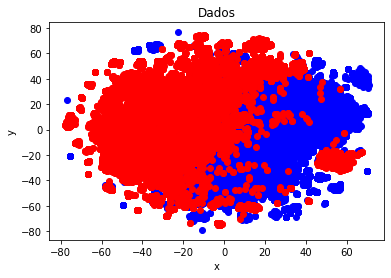

In [8]:
# df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]
#
# df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]
#
# plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')
#
# plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')
#
# plt.title('Dados')
# plt.xlabel('x')
# plt.ylabel('y')
#
# plt.show()

# Validação

In [8]:
X_treino, X_teste, y_treino, y_teste = train_test_split(bertDataframe,target,test_size=0.2)
X_treino

NameError: name 'bertDataframe' is not defined

In [8]:
model = keras.models.Sequential([

########## MLP
keras.layers.Flatten(input_shape=(X_treino.shape[1],)),
#keras.layers.Dense(300, activation="relu"),
#keras.layers.Dense(1000, activation="relu"),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),

keras.layers.Dense(len(set(target)), activation="softmax")
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2100)              0         
                                                                 
 dense (Dense)               (None, 300)               630300    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 660,602
Trainable params: 660,602
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [11]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4,
                                                  mode='min')]

callbacks.append(
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True))

history = model.fit(np.array(X_treino), np.array(y_treino), epochs=200,
                    validation_split=0.05,
                    callbacks=callbacks
                    )

Epoch 1/200
792/792 [==============================] - 3s 2ms/step - loss: 0.1140 - accuracy: 0.9653 - val_loss: 0.0808 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 2/200
792/792 [==============================] - 2s 2ms/step - loss: 0.0307 - accuracy: 0.9889 - val_loss: 0.0619 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 3/200
792/792 [==============================] - 2s 2ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0638 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 4/200
792/792 [==============================] - 2s 2ms/step - loss: 0.0091 - accuracy: 0.9969 - val_loss: 0.0815 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 5/200
792/792 [==============================] - 2s 2ms/step - loss: 0.0360 - accuracy: 0.9934 - val_loss: 0.0784 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 6/200
792/792 [==============================] - 2s 2ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0850 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 7/200
792/792 [==============================] - 2s 2ms/st

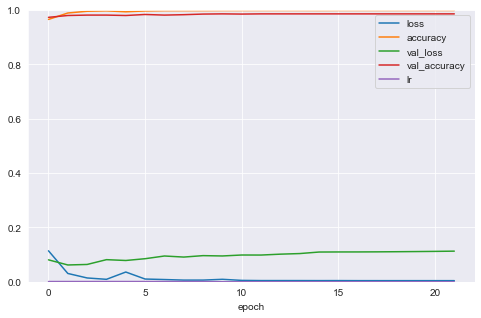

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [30]:
model.evaluate(np.array(bertDataframe.values), np.array(target))

1042/1042 [==============================] - 2s 2ms/step - loss: 0.0249 - accuracy: 0.9923


[0.024894481524825096, 0.9922617673873901]

1042/1042 [==============================] - 1s 963us/step


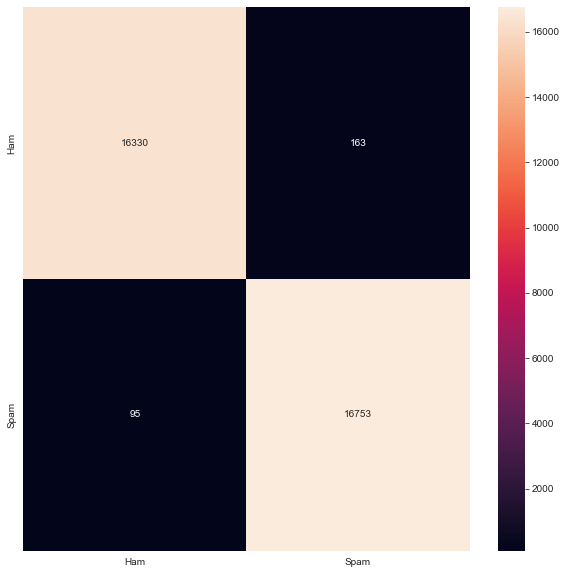

In [34]:
cm = confusion_matrix(target,np.argmax(model.predict(bertDataframe.values), axis=-1))

labels = ["Ham", "Spam"]

cm_df = pd.DataFrame(cm, columns=labels)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

plt.show()